In [1]:
import sys 
sys.path.append("C:/Users/levyb/Documents/Masters Data Science - 2nd Year/deepHedgingRL")
import gymnasium as gym
import numpy as np
import torch as th
import matplotlib.pyplot as plt
import tensorflow as tf
from src.pricing.asset_price_process import GBM
from src.pricing.option_price_process import BSM
from src.custom_environments.HedgeEnv_PPO import env_hedging_ppo
from torch import nn



In [2]:
mu = 0
dt = 1/5
T = 10
num_steps = int(T/dt)
s_0 = float(100)
strike_price = s_0
sigma = 0.01
r = 0

def cost(delta_h, multiplier):
    TickSize = 0.1
    return multiplier * TickSize * (np.abs(delta_h) + 0.01 * delta_h**2)


apm = GBM(mu=mu, dt=dt, s_0=s_0, sigma=sigma)
opm = BSM(strike_price=strike_price, risk_free_interest_rate=r, volatility=sigma, T=T, dt=dt)


env = env_hedging_ppo(asset_price_model=apm, dt=dt, T=T, num_steps=num_steps, cost_multiplier = 0, tick_size=0.01,
                     L=1, strike_price=strike_price, integer_holdings=True, initial_holding=0, mode="PL", shares_per_contract=100,
                  option_price_model=opm)



In [13]:
from stable_baselines3 import PPO
from gym import spaces
from typing import Callable, Tuple
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.utils import get_schedule_fn
from stable_baselines3.common.env_util import make_vec_env
from torch.nn import functional as F
import os 


n_envs = 2
vec_env = make_vec_env(lambda:env_hedging_ppo(asset_price_model=apm, dt=dt, T=T, num_steps=num_steps, cost_multiplier = 0, tick_size=0.01,
                     L=1, strike_price=strike_price, integer_holdings=True, initial_holding=0, mode="PL",
                  option_price_model=opm) , n_envs= n_envs)



class Du_Custom_Network(nn.Module):
    
    def __init__(self, feature_dim: int = 5,last_layer_dim_pi: int = 201,last_layer_dim_vf: int = 1, hidden_dim: int = 90):
        super().__init__()

        # Save output dimensions, used to create the distributions
        self.hidden_dim = hidden_dim
        self.latent_dim_pi = last_layer_dim_pi
        self.latent_dim_vf = last_layer_dim_vf

        # Policy network with 5 hidden layers, batch normalization before ReLU
        self.policy_net = nn.Sequential(
            
            nn.Linear(feature_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, last_layer_dim_pi)
        )

        # Value network with 5 hidden layers, batch normalization before ReLU
        self.value_net = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, last_layer_dim_vf)
        )

    def forward(self, features: th.Tensor) -> Tuple[th.Tensor, th.Tensor]:
        """
        :return: (th.Tensor, th.Tensor) latent_policy, latent_value of the specified network.
            If all layers are shared, then ``latent_policy == latent_value``
        """
        return self.forward_actor(features), self.forward_critic(features)

    def forward_actor(self, features: th.Tensor) -> th.Tensor:
        logits = self.policy_net(features)
        return F.softmax(logits, dim=-1) 

    def forward_critic(self, features: th.Tensor) -> th.Tensor:
        return self.value_net(features)


class Du_ActorCriticPolicy(ActorCriticPolicy):
    def __init__(
        self,
        observation_space: spaces.Space,
        action_space: spaces.Space,
        lr_schedule: Callable[[float], float],
        *args,
        **kwargs,
    ):
        # Disable orthogonal initialization
        kwargs["ortho_init"] = False
        super().__init__(
            observation_space,
            action_space,
            lr_schedule,
            *args,
            **kwargs,
        )

    def _build_mlp_extractor(self) -> None:
        self.mlp_extractor =Du_Custom_Network(self.features_dim)


# Set up directories for logging and saving models
log_dir = "C:/Users/levyb/Documents/Masters Data Science - 2nd Year/deepHedgingRL/results/PPO/du/logs"

models_dir = "C:/Users/levyb/Documents/Masters Data Science - 2nd Year/deepHedgingRL/models/PPO/du"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

def linear_decay_schedule(initial_value: float, final_value:float) -> Callable[[float], float]:
    def schedule(progress: float) -> float:
        # Linearly decay the learning rate from `initial_value` to 0
        return initial_value - progress*(initial_value- final_value)
    return schedule

learning_rate_schedule = get_schedule_fn(linear_decay_schedule(1e-4, 1e-5))

# Instantiate and train the PPO model as per the Du paper
# model = PPO(
#     policy= Du_ActorCriticPolicy, 
#     env= vec_env, 
#     learning_rate=1e-4,
#     n_steps= 1500, #update every 15000 episodes
#     n_epochs = 5, 
#     clip_range =0.2, 
#     verbose=1,
#     gae_lambda=0.99, 
#     gamma=0.85,
#     ent_coef=0.2,  # Entropy coefficient for exploration #check c1 parameter and c2 parameter 0
#     vf_coef=0.5,  # Value function coefficient
#     normalize_advantage= True,
#     tensorboard_log=log_dir,
#     device= "auto"
# )


# Train the model in increments and save after each block of timesteps
# TIMESTEPS = 1000000
# for i in range(1,20):
#     model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name="PPO")
#     model.save(f"{models_dir}/ppo_{TIMESTEPS*i}")



In [ ]:
# from scipy.ndimage import gaussian_filter1d

# # Calculate moving average to smooth the curve
# window_size = 50 # Adjust the window size as needed
# smoothed_rewards = np.convolve(callback.rewards, np.ones(window_size)/window_size, mode='valid')

# # Alternatively, you can use Gaussian smoothing for more flexible control:
# # smoothed_rewards = gaussian_filter1d(callback.rewards, sigma=2)

# # Adjust train_data_point to match the length of smoothed_rewards
# train_data_point = np.arange(len(smoothed_rewards)) * callback.check_freq

# plt.figure(figsize=(10, 6))
# plt.plot(train_data_point, smoothed_rewards, label='Reward', color='green')
# plt.xlabel('Timesteps', fontsize=14)
# plt.ylabel('Reward', fontsize=14)
# plt.title('Convergence of PPO - Reward Over Training', fontsize=16)
# plt.legend(loc='best')
# plt.grid(True)
# plt.savefig("PPO_Convergence_1500000.png")
# plt.show()

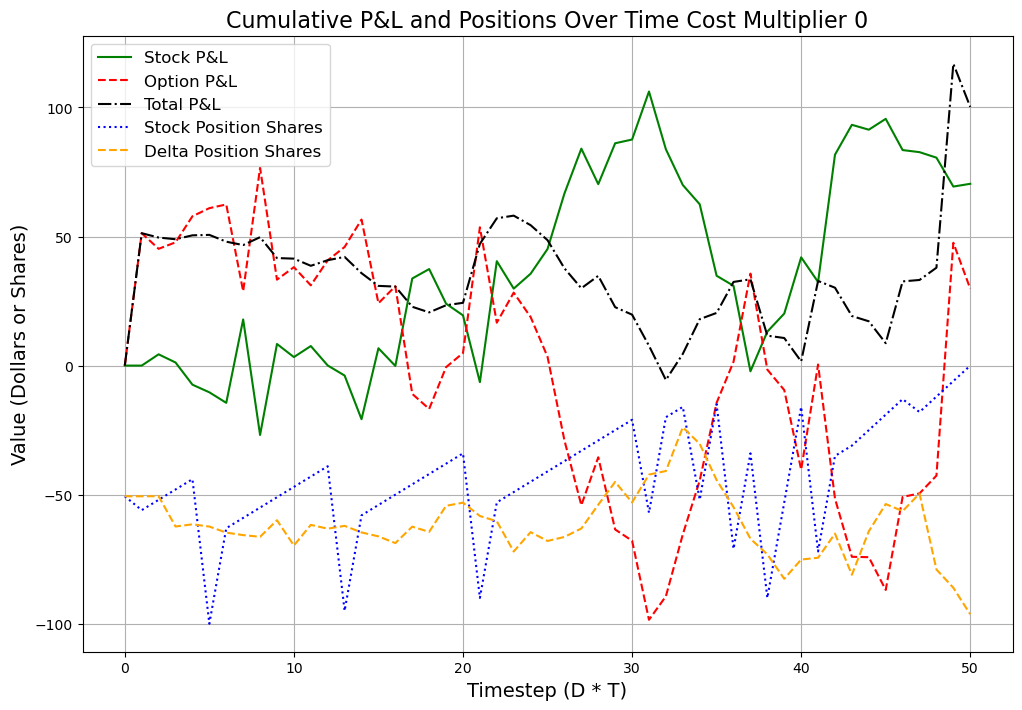

In [77]:
custom_objects = {"policy_class": Du_ActorCriticPolicy}
model = PPO.load("C:/Users/levyb/Documents/Masters Data Science - 2nd Year/deepHedgingRL/models/PPO/du/PPO_7/ppo_49000000", custom_objects= custom_objects)

num_episodes = 1

for episode in range(num_episodes): 
    state = env.reset(seed =2024)
    done = False
    cum_option_pnl = 0
    cum_stock_pnl = 0
    cum_cost_pnl = 0
    option_pnls = [0]
    stock_pnls = [0]
    cost_pnls = [0]
    total_pnl = [0]
    stock_pos_shares =[-round(state[0][4], 2)]
    delta_pos_shares = [-round(state[0][4], 2)]
    
    while not done:
        current_holdings, current_asset_price, current_ttm, current_option_value, current_delta = env.get_state()
        delta_action =  -round(current_delta, 2)
        action, _states = model.predict(env.get_state(), deterministic = True)
        next_state, reward, done,done,  info = env.step(action)
        next_holdings, next_asset_price, next_ttm, next_option_value, next_delta = next_state
        delta_h =   next_holdings -current_holdings
        option_pnl = next_option_value-current_option_value
        stock_pnl = current_holdings*(next_asset_price -current_asset_price)- cost(delta_h, 0)
        cum_option_pnl += option_pnl
        cum_stock_pnl += stock_pnl
        cum_cost_pnl += cost(delta_h, 0)

        option_pnls.append(cum_option_pnl)
        stock_pnls.append(cum_stock_pnl)
        cost_pnls.append(cum_cost_pnl)
        total_pnl.append(cum_option_pnl+cum_stock_pnl)
        stock_pos_shares.append(next_holdings)
        delta_pos_shares.append(delta_action)

        if done:
            state = env.reset()

    time_axis = np.linspace(0, num_steps, num_steps + 1)
    plt.figure(figsize=(12, 8))
    plt.plot(time_axis, stock_pnls, label='Stock P&L', color='green', linestyle='-')
    plt.plot(time_axis, option_pnls, label='Option P&L', color='red', linestyle='--')
    #plt.plot(time_axis, cost_pnls, label='Cost P&L', color='magenta', linestyle='--')
    plt.plot(time_axis, total_pnl, label='Total P&L', color='black', linestyle='-.')
    plt.plot(time_axis, stock_pos_shares, label='Stock Position Shares', color='blue', linestyle=':')
    plt.plot(time_axis, delta_pos_shares, label='Delta Position Shares', color='orange', linestyle='--')

    # Add labels, title, and legend
    plt.xlabel('Timestep (D * T)', fontsize=14)
    plt.ylabel('Value (Dollars or Shares)', fontsize=14)
    plt.title('Cumulative P&L and Positions Over Time Cost Multiplier 0', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)

    plt.show()

C:\Users\levyb\AppData\Local\Temp\ipykernel_16144\1233730351.py:96: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cost_pnls_ppo, label='Policy: ppo', shade=True)
C:\Users\levyb\AppData\Local\Temp\ipykernel_16144\1233730351.py:97: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cost_pnls_dh, label='Policy: $\delta_{DH}$', shade=True)
C:\Users\levyb\AppData\Local\Temp\ipykernel_16144\1233730351.py:105: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot( total_pnls_vol_ppo, label='Policy: ppo', shade=True)
C:\Users\levyb\AppData\Local\Temp\ipykernel_16144\1233730351.py:106: FutureWarning: 

`shade` is now deprecated in favor of `f

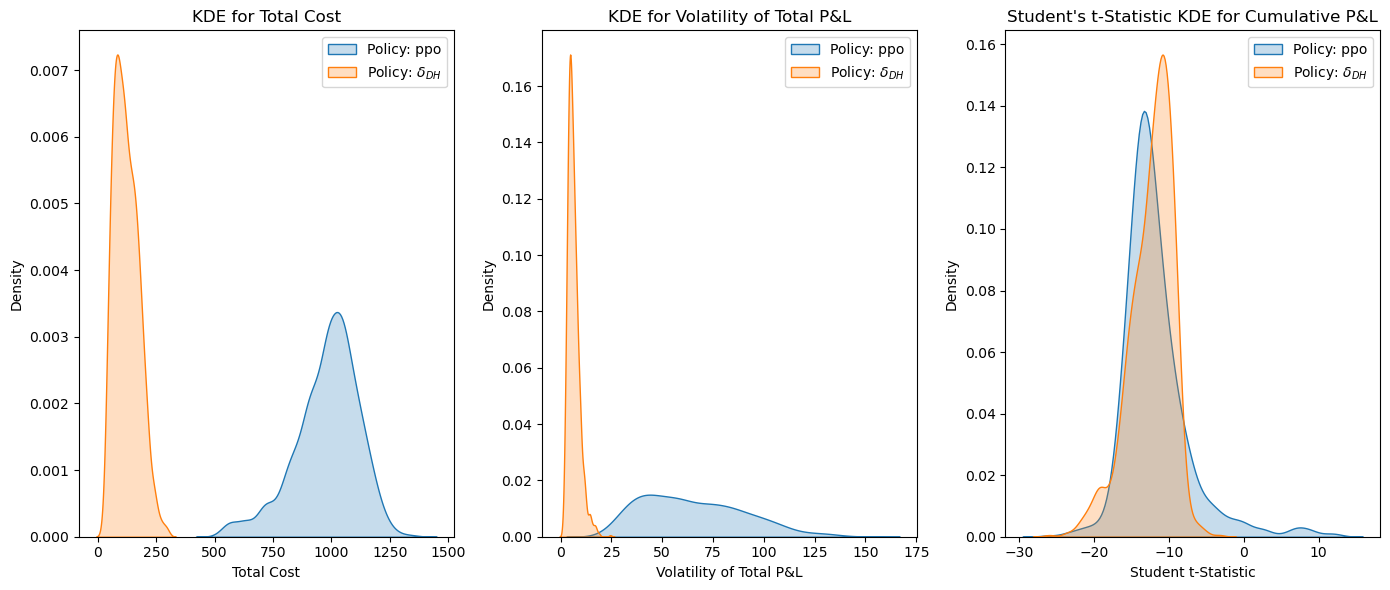

In [78]:
def student_t_statistic(data):
    n = len(data)
    sample_mean = np.mean(data)
    sample_std = np.std(data, ddof=1)
    t_statistic = sample_mean / (sample_std / np.sqrt(n))
    return t_statistic

# Getting kernel density estimates for cost and volatility
num_episodes = 1000
cost_pnls_dh = []
cost_pnls_ppo = []
total_pnls_vol_dh = []
total_pnls_vol_ppo = []
t_stat_pnls_dh = []
t_stat_pnls_ppo = []

for episode in range(num_episodes): 
    state = env.reset()
    done = False
    samp_cost_pnl_dh = 0
    samp_cost_pnl_ppo = 0

    pnl_diffs_ppo = []
    pnl_diffs_dh = []
    
    previous_pnl_ppo = 0
    previous_pnl_dh = 0
    
    total_pnl_ppo = 0
    total_pnl_dh = 0
    samp_total_pnl_dh = []
    samp_total_pnl_ppo = []

    while not done:
        current_holdings, current_asset_price, current_ttm, current_option_value, current_delta= env.get_state()

        action, _states = model.predict(env.get_state(), deterministic=True)
        next_state, reward, done,done,  info = env.step(action)
        next_holdings, next_asset_price, next_ttm, next_option_value, next_delta = next_state
        
        delta_h_ppo = next_holdings-current_holdings
        delta_h_dh = (-round(next_delta, 2)) - (-round(current_delta, 2))


        # Cost calculations for both policies
        samp_cost_pnl_dh += cost(delta_h_dh, 5)
        samp_cost_pnl_ppo += cost(delta_h_ppo, 5)

        # P&L differences between steps
        pnl_ppo = ((next_option_value - current_option_value) - current_holdings * (next_asset_price - current_asset_price) - cost(delta_h_ppo, 5))
        pnl_dh = ((next_option_value - current_option_value) + (-round(current_delta, 2)) * (next_asset_price - current_asset_price) - cost(delta_h_dh, 5))
        
        pnl_diffs_ppo.append(pnl_ppo - previous_pnl_ppo)
        pnl_diffs_dh.append(pnl_dh - previous_pnl_dh)

        # Update previous P&L
        previous_pnl_ppo = pnl_ppo
        previous_pnl_dh = pnl_dh

        # Accumulate the cumulative P&L for each policy
        total_pnl_ppo+= pnl_ppo
        total_pnl_dh += pnl_dh
        samp_total_pnl_ppo.append(total_pnl_ppo)
        samp_total_pnl_dh.append(total_pnl_dh)



        if done:
            # Volatility is the standard deviation of P&L differences
            vol_ppo = np.std(pnl_diffs_ppo)
            vol_dh = np.std(pnl_diffs_dh)

            # Calculate student t-statistic based on cumulative P&L at the end of the episode
            t_stat_pnl_ppo = student_t_statistic(samp_total_pnl_ppo)  # Use cumulative P&L
            t_stat_pnl_dh = student_t_statistic(samp_total_pnl_dh)  # Use cumulative P&L

            # Append cost and volatility for this episode
            cost_pnls_ppo.append(samp_cost_pnl_ppo)
            cost_pnls_dh.append(samp_cost_pnl_dh)
            total_pnls_vol_ppo.append(vol_ppo)
            total_pnls_vol_dh.append(vol_dh)
            t_stat_pnls_ppo.append(t_stat_pnl_ppo)
            t_stat_pnls_dh.append(t_stat_pnl_dh)

            state = env.reset()

# Plotting the KDE and results
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Plot kernel density estimates for total cost
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
sns.kdeplot(cost_pnls_ppo, label='Policy: ppo', shade=True)
sns.kdeplot(cost_pnls_dh, label='Policy: $\delta_{DH}$', shade=True)
plt.title('KDE for Total Cost')
plt.xlabel('Total Cost')
plt.ylabel('Density')
plt.legend()

# Plot kernel density estimates for volatility of total P&L
plt.subplot(1, 3, 2)
sns.kdeplot( total_pnls_vol_ppo, label='Policy: ppo', shade=True)
sns.kdeplot(total_pnls_vol_dh, label='Policy: $\delta_{DH}$', shade=True)
plt.title('KDE for Volatility of Total P&L')
plt.xlabel('Volatility of Total P&L')
plt.ylabel('Density')
plt.legend()

# Plot KDE for Student's t-statistic of Cumulative P&L
plt.subplot(1, 3, 3)
sns.kdeplot(t_stat_pnls_ppo, label='Policy: ppo', shade=True)
sns.kdeplot(t_stat_pnls_dh, label='Policy: $\delta_{DH}$', shade=True)
plt.title("Student's t-Statistic KDE for Cumulative P&L")
plt.xlabel('Student t-Statistic')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()


C:\Users\levyb\AppData\Local\Temp\ipykernel_16556\2360863198.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot([x/100 for x in cost_pnls_ppo], label='Policy: ppo', shade=True)
C:\Users\levyb\AppData\Local\Temp\ipykernel_16556\2360863198.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot([x/100 for x in cost_pnls_dh], label='Policy: $\delta_{DH}$', shade=True)
C:\Users\levyb\AppData\Local\Temp\ipykernel_16556\2360863198.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot([x/100 for x in total_pnls_vol_ppo], label='Policy: ppo', shade=True)
C:\Users\levyb\AppData\Local\Temp\ipykernel_16556\2360863198.py:14: FutureWarni

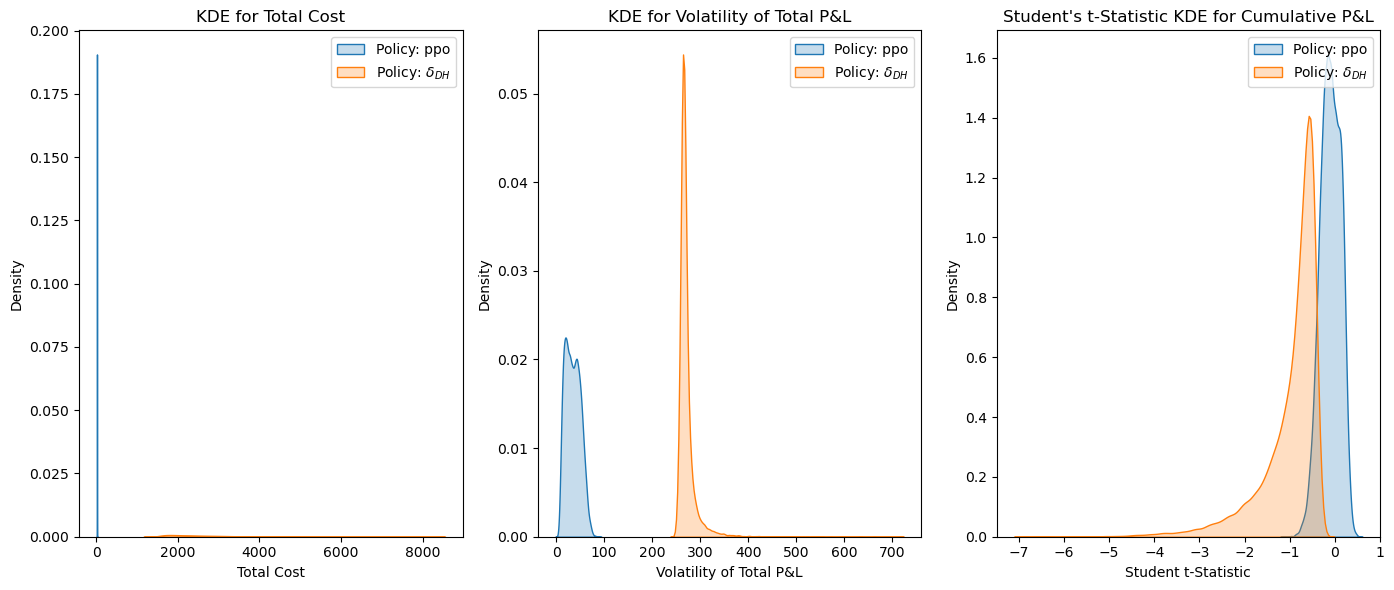

In [32]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
sns.kdeplot([x/100 for x in cost_pnls_ppo], label='Policy: ppo', shade=True)
sns.kdeplot([x/100 for x in cost_pnls_dh], label='Policy: $\delta_{DH}$', shade=True)
plt.title('KDE for Total Cost')
plt.xlabel('Total Cost')
plt.ylabel('Density')
plt.legend()

# Plot kernel density estimates for volatility of total P&L
plt.subplot(1, 3, 2)
sns.kdeplot([x/100 for x in total_pnls_vol_ppo], label='Policy: ppo', shade=True)
sns.kdeplot([x/100 for x in total_pnls_vol_dh], label='Policy: $\delta_{DH}$', shade=True)
plt.title('KDE for Volatility of Total P&L')
plt.xlabel('Volatility of Total P&L')
plt.ylabel('Density')
plt.legend()

# Plot KDE for Student's t-statistic of Cumulative P&L
plt.subplot(1, 3, 3)
sns.kdeplot( [x/50 for x in t_stat_pnls_ppo], label='Policy: ppo', shade=True)
sns.kdeplot([x/50 for x in t_stat_pnls_dh], label='Policy: $\delta_{DH}$', shade=True)
plt.title("Student's t-Statistic KDE for Cumulative P&L")
plt.xlabel('Student t-Statistic')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()


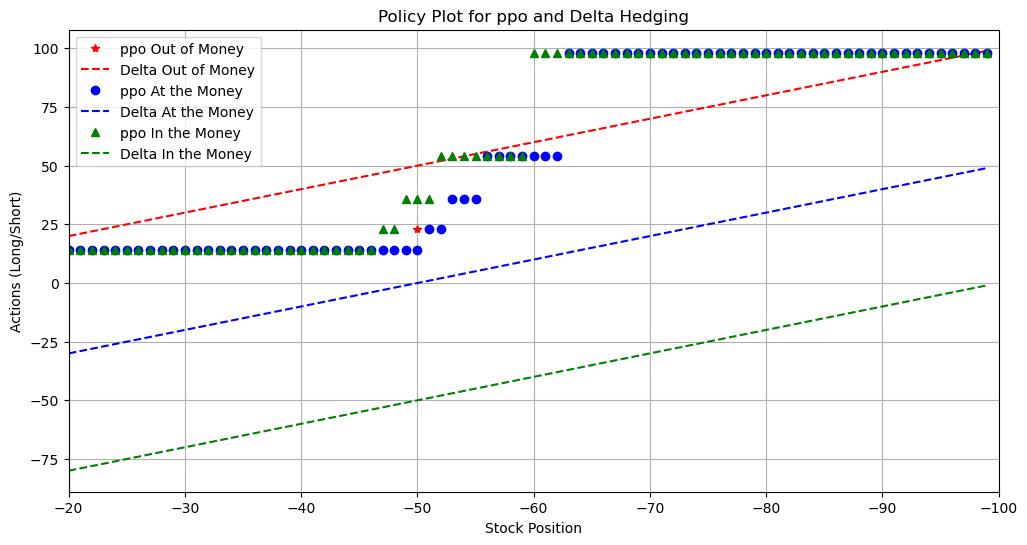

In [53]:
# Define parameters for the BSM model
delta_mapping = np.arange(-100, 101)
strike_price = 100
env.reset()
# Define stock prices for out-of-the-money, at-the-money, and in-the-money scenarios
stock_prices = [98, 100, 102] 
time_to_maturity = 1/5

# Initialize arrays to store actions
ppo_actions_out_of_money = []
ppo_actions_at_money = []
ppo_actions_in_money = []


stock_positions = np.arange(-20, -100, -1)  # Adjust as necessary
deltas_out= np.arange(0.20,1, 0.01)
deltas_at = np.arange(-0.30, 0.50, 0.01)
deltas_in = np.arange(-0.80,0, 0.01)



for i in range(len(stock_positions)):
    # Time to maturity remains constant for this plot
    ttm = time_to_maturity  # Time to maturity in years

    # Out-of-the-money (S = 98)
    S_out = 98
    # Compute option price and delta
    option_price_out = opm.compute_option_price(ttm, S_out, mode='ttm')
    env.set_state(stock_positions[i], S_out, ttm, option_price_out, deltas_out[i])
    action_out, _ = model.predict(env.get_state(), deterministic=True)
    ppo_actions_out_of_money.append(delta_mapping[action_out])

    # At-the-money (S = 100)
    S_at = 100
    option_price_at = opm.compute_option_price(ttm, S_at, mode='ttm')
    env.set_state(stock_positions[i], S_at, ttm, option_price_at,deltas_at[i])
    action_at, _ = model.predict(env.get_state(), deterministic=True)
    ppo_actions_at_money.append(delta_mapping[action_at])


    # In-the-money (S = 102)
    S_in = 102
    option_price_in = opm.compute_option_price(ttm, S_in, mode='ttm')
    env.set_state(stock_positions[i], S_in, ttm, option_price_in, deltas_in[i])
    action_in, _ = model.predict(env.get_state(), deterministic=True)
    ppo_actions_in_money.append(delta_mapping[action_in])

# Plotting
plt.figure(figsize=(12, 6))

# Out-of-the-money
plt.plot(stock_positions, ppo_actions_out_of_money, label="ppo Out of Money", marker="*", linestyle="", color= "red")
plt.plot(stock_positions, [x*100 for x in deltas_out], label="Delta Out of Money", linestyle="--",color= "red")

# At-the-money
plt.plot(stock_positions, ppo_actions_at_money, label="ppo At the Money", marker="o", linestyle="", color = "blue")
plt.plot(stock_positions, [x*100 for x in deltas_at], label="Delta At the Money", linestyle="--", color = "blue")

# In-the-money
plt.plot(stock_positions, ppo_actions_in_money, label="ppo In the Money", marker="^", linestyle="", color ="green")
plt.plot(stock_positions, [x*100 for x in deltas_in], label="Delta In the Money", linestyle="--", color = "green")

plt.xlim(-20, -100)
plt.title("Policy Plot for ppo and Delta Hedging")
plt.xlabel("Stock Position")
plt.ylabel("Actions (Long/Short)")
plt.legend()
plt.grid(True)
plt.savefig("PPO Policy Plot")
plt.show()
